In [1]:
import pandas as pd
import numpy as np

In [34]:
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
from sklearn import preprocessing

# 1. Load data

In [4]:
df = pd.read_csv('ratings_small.csv')

In [5]:
df.shape

(100004, 4)

In [11]:
df.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100004.0,3.470113e+02,1.951638e+02,1.0,182.0,3.670000e+02,5.200000e+02,6.710000e+02
movieId,100004.0,1.254866e+04,2.636920e+04,1.0,1028.0,2.406500e+03,5.418000e+03,1.639490e+05
rating,100004.0,3.543608e+00,1.058064e+00,0.5,3.0,4.000000e+00,4.000000e+00,5.000000e+00
timestamp,100004.0,1.129639e+09,1.916858e+08,789652009.0,965847824.0,1.110422e+09,1.296192e+09,1.476641e+09


# 2. Data preprocessing

In [17]:
encoders = {
    'user': preprocessing.LabelEncoder(),
    'movie': preprocessing.LabelEncoder(),
}

In [18]:
df['encoded_user'] = encoders['user'].fit_transform(df.userId)
df['encoded_movie'] = encoders['movie'].fit_transform(df.movieId)

- If rating is >= 4, we consider there is a positive edge for this user-movie pair

In [22]:
df['pos_edge'] = df['rating'].apply(lambda x: 1 if x >=4 else 0)

In [30]:
df_pos = df[df['pos_edge']==1].reset_index()
df_neg = df[df['pos_edge']==0].reset_index()

In [33]:
df_pos.shape, df_neg.shape

((51568, 8), (48436, 8))

In [28]:
print('Number of unique users:', df_pos['userId'].nunique())
print('Number of unique movies:', df_pos['movieId'].nunique())

Number of unique users: 671
Number of unique movies: 6170


In [20]:
df['encoded_movie'].unique()

array([  30,  833,  859, ...,  115, 3712, 4629], dtype=int64)

## 2.1 basic EDA

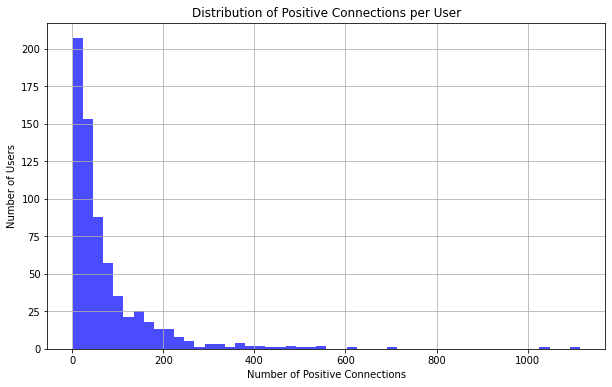

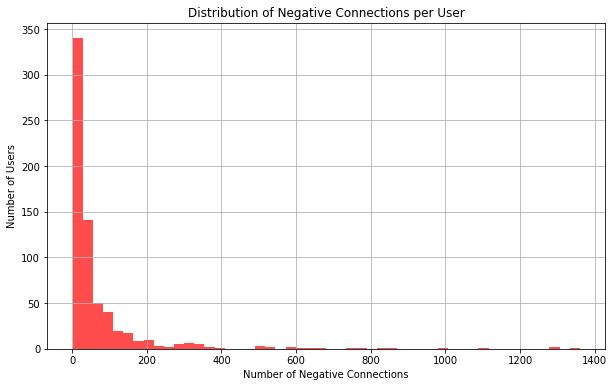

In [77]:
user_connections_count = df_pos.groupby('encoded_user')['encoded_movie'].count()

# Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(user_connections_count, bins=50, color='blue', alpha=0.7)
plt.xlabel('Number of Positive Connections')
plt.ylabel('Number of Users')
plt.title('Distribution of Positive Connections per User')
plt.grid(True)
plt.show()


user_connections_count = df_neg.groupby('encoded_user')['encoded_movie'].count()

# Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(user_connections_count, bins=50, color='red', alpha=0.7)
plt.xlabel('Number of Negative Connections')
plt.ylabel('Number of Users')
plt.title('Distribution of Negative Connections per User')
plt.grid(True)
plt.show()

In [75]:
def plot_bipartite_graph(df_pos, df_neg, user_id):
    # Create an empty bipartite graph
    G = nx.Graph()

    # Add nodes for positive connections (movies) and negative connections (movies)
    positive_movies = set(df_pos[df_pos['encoded_user'] == user_id]['encoded_movie'])
    negative_movies = set(df_neg[df_neg['encoded_user'] == user_id]['encoded_movie'])
    for movie_id in positive_movies:
        G.add_node(movie_id, bipartite=1)
    for movie_id in negative_movies:
        G.add_node(movie_id, bipartite=1)

    # Add the user node
    G.add_node(user_id, bipartite=0)

    # Add edges for positive connections (blue color)
    for _, row in df_pos[df_pos['encoded_user'] == user_id].iterrows():
        G.add_edge(user_id, row['encoded_movie'], color='blue', label=row['encoded_movie'])

    # Add edges for negative connections (red color)
    for _, row in df_neg[df_neg['encoded_user'] == user_id].iterrows():
        G.add_edge(user_id, row['encoded_movie'], color='red', label=row['encoded_movie'])

    # Separate the bipartite nodes for layout
    pos = nx.bipartite_layout(G, nodes=[n for n, d in G.nodes(data=True) if d['bipartite'] == 0])
    
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    
    nx.draw(G, pos, with_labels=True, font_size=8, node_color='skyblue', node_size=500, edge_color=colors)
    
    plt.title(f"Bipartite Graph for User {user_id}")
    plt.show()


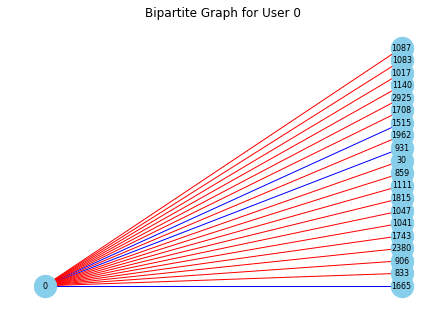

In [76]:
plot_bipartite_graph(df_pos, df_neg, user_id=0)

# 3. Graph preprocessing

In [107]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

In [101]:
# Merge positive and negative edges dataframes
df_merged = pd.concat([df_pos, df_neg], ignore_index=True)

# Shuffle the merged dataframe
df_merged_shuffled = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled dataframe into train and test sets (70% training, 30% testing)
train_ratio = 0.8
train_size = int(train_ratio * len(df_merged_shuffled))

train_data = df_merged_shuffled.iloc[:train_size]
test_data = df_merged_shuffled.iloc[train_size:]

In [102]:
train_data.pos_edge.mean(), test_data.pos_edge.mean()

(0.5145182055672912, 0.52022398880056)

TODO

- Crear el train edge index unicamente con aristas POSITIVAS del train. Esto actualizara los embeddings de los nodos de usuarios y peliculas
- Modificar el modelo GNNMessagePassing para unicamente devolver actualizacion de embeddings de usuarios y peliculas
- training loop, etc..
- Aprender a usar data loaders de torch geom

In [194]:
train_data_pos = train_data[train_data.pos_edge==1].reset_index(drop=True)
train_data_neg = train_data[train_data.pos_edge==0].reset_index(drop=True)

test_data_pos = test_data[test_data.pos_edge==1].reset_index(drop=True)
test_data_neg = test_data[test_data.pos_edge==0].reset_index(drop=True)

# 4. Graph model

In [633]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, LGConv, SAGEConv, GAT

class GNNMessagePassing(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim, hidden_dim):
        super().__init__()
        
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.movie_embeddings = nn.Embedding(num_movies, embedding_dim)
        self.conv_1 = SAGEConv(embedding_dim, hidden_dim)
        self.conv_2 = SAGEConv(hidden_dim, hidden_dim)

    def forward(self, edge_index):
        # Get all user and movie embeddings
        user_embeds = self.user_embeddings.weight
        movie_embeds = self.movie_embeddings.weight

        # Concatenate user and movie embeddings for message passing
        x = torch.cat([user_embeds, movie_embeds], dim=0)

        # Perform graph convolution (message passing)
        x = F.gelu(self.conv_1(x, edge_index))
        x = self.conv_2(x, edge_index)

        # Separate updated embeddings for users and movies
        user_updated = x[:user_embeds.shape[0]]
        movie_updated = x[user_embeds.shape[0]:]

        return dict(user_h=user_updated, movie_h=movie_updated)

    
class DotPredictor(nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        self.linear_1 = nn.Linear(in_dim, in_dim)
        self.linear_2 = nn.Linear(in_dim, out_dim)
    
    def forward(self, user_index, movie_index, user_feat, movie_feat):

        dot = user_feat[user_index]*movie_feat[movie_index]
        out = F.relu(self.linear_1(dot))
        out = self.linear_2(out)
        
        return out

#### Sanity Check

In [543]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

embedding_dim=2
hidden_dim = 2

In [544]:
gnn_model = GNNMessagePassing(n_users, n_movies, embedding_dim, hidden_dim)

dot_predictor = DotPredictor(hidden_dim, 1)

In [545]:
gnn_model.user_embeddings.weight.grad

In [546]:
u = np.concatenate([train_data_pos['encoded_user'].values, train_data_pos['encoded_movie'].values])
v = np.concatenate([train_data_pos['encoded_movie'].values, train_data_pos['encoded_user'].values])

In [547]:
u.shape, v.shape

((82326,), (82326,))

In [548]:
concatenated_array = np.stack([u,v], axis=0)

In [549]:
concatenated_array.shape

(2, 82326)

In [550]:
edge_index = torch.tensor(concatenated_array, dtype=torch.long, requires_grad=False)

In [551]:
h = gnn_model(edge_index)

In [552]:
h

{'user_h': tensor([[-0.2463, -0.3433],
         [-0.1589, -0.1916],
         [-0.1371, -0.1644],
         ...,
         [-0.0520, -0.0721],
         [-0.0654, -0.0878],
         [-0.0500, -0.0779]], grad_fn=<SliceBackward0>),
 'movie_h': tensor([[-0.0357, -0.0436],
         [-0.7099, -0.6371],
         [-0.1014, -0.1083],
         ...,
         [-0.7530, -1.1040],
         [-1.7203, -2.0836],
         [-0.0034, -0.0065]], grad_fn=<SliceBackward0>)}

In [553]:
u,v = edge_index[:,0].unsqueeze(1)

In [554]:
dot_predictor(u,v,h['user_h'], h['movie_h'])

tensor([[-0.1645]], grad_fn=<AddmmBackward0>)

In [555]:
result = dot_predictor(u,v,h['user_h'], h['movie_h'])
result

tensor([[-0.1645]], grad_fn=<AddmmBackward0>)

# 5. Train loop

In [634]:
u = np.concatenate([train_data_pos['encoded_user'].values, train_data_pos['encoded_movie'].values])
v = np.concatenate([train_data_pos['encoded_movie'].values, train_data_pos['encoded_user'].values])
concatenated_array = np.stack([u,v], axis=0)
edge_index = torch.tensor(concatenated_array, dtype=torch.long, requires_grad=False)

In [635]:
train_pos_edges = torch.tensor(np.array([train_data_pos['encoded_user'].values, train_data_pos['encoded_movie'].values]), dtype=torch.long)
train_neg_edges = torch.tensor(np.array([train_data_neg['encoded_user'].values, train_data_neg['encoded_movie'].values]), dtype=torch.long)

test_pos_edges = torch.tensor(np.array([test_data_pos['encoded_user'].values, test_data_pos['encoded_movie'].values]), dtype=torch.long)
test_neg_edges = torch.tensor(np.array([test_data_neg['encoded_user'].values, test_data_neg['encoded_movie'].values]), dtype=torch.long)


train_pos_target = torch.ones(train_pos_edges.shape[1],1)
train_neg_target = torch.zeros(train_neg_edges.shape[1],1)
test_pos_target = torch.ones(test_pos_edges.shape[1],1)
test_neg_target = torch.zeros(test_neg_edges.shape[1],1)

In [636]:
import torch.optim as optim
import itertools

In [677]:
# Global hyperparameters
n_epochs = 160
learning_rate = 0.005


#gnn parameters
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

embedding_dim=2
hidden_dim = 8

In [678]:
gnn_model = GNNMessagePassing(n_users, n_movies, embedding_dim, hidden_dim)
dot_predictor = DotPredictor(hidden_dim, 1)

In [679]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.NAdam(itertools.chain(gnn_model.parameters(), 
                                       dot_predictor.parameters()), lr=learning_rate)

In [680]:
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

# Initialize an empty DataFrame to log the training and test losses per epoch
losses_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Test Loss', 'Train ROC AUC', 'Test ROC AUC'])

# Training loop
for epoch in range(n_epochs):
    gnn_model.train()
    dot_predictor.train()
    
    ### Message passing on training positive edges
    optimizer.zero_grad()
    h = gnn_model(edge_index)
    
    u, v = train_pos_edges
    train_pos_logits = dot_predictor(u, v, h['user_h'], h['movie_h'])
    u, v = train_neg_edges
    train_neg_logits = dot_predictor(u, v, h['user_h'], h['movie_h'])
    
    pos_loss = criterion(train_pos_logits, train_pos_target)
    neg_loss = criterion(train_neg_logits, train_neg_target)
    
    loss = pos_loss + neg_loss

    # Backward pass and update weights
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        u, v = test_pos_edges
        test_pos_logits = dot_predictor(u, v, h['user_h'], h['movie_h'])
        u, v = test_neg_edges
        test_neg_logits = dot_predictor(u, v, h['user_h'], h['movie_h'])
        
        pos_loss = criterion(test_pos_logits, test_pos_target)
        neg_loss = criterion(test_neg_logits, test_neg_target)
    
        test_loss = pos_loss + neg_loss
        
        # Calculate the ROC AUC for both training and test sets
        train_labels = torch.cat([train_pos_target, train_neg_target])
        train_logits = torch.cat([train_pos_logits, train_neg_logits])
        test_labels = torch.cat([test_pos_target, test_neg_target])
        test_logits = torch.cat([test_pos_logits, test_neg_logits])

        train_roc_auc = roc_auc_score(train_labels.numpy(), torch.sigmoid(train_logits).numpy())
        test_roc_auc = roc_auc_score(test_labels.numpy(), torch.sigmoid(test_logits).numpy())
    
    losses_df = losses_df.append({'Epoch': epoch + 1,
                                  'Train Loss': loss.item(),
                                  'Test Loss': test_loss.item(),
                                  'Train ROC AUC': train_roc_auc,
                                  'Test ROC AUC': test_roc_auc},
                                 ignore_index=True)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {loss.item():.4f}, Train ROC AUC: {train_roc_auc:.4f}, Test Loss: {test_loss.item():.4f}, Test ROC AUC: {test_roc_auc:.4f}")


Epoch 5/160, Train Loss: 1.3871, Train ROC AUC: 0.5017, Test Loss: 1.3867, Test ROC AUC: 0.5054
Epoch 10/160, Train Loss: 1.3846, Train ROC AUC: 0.5225, Test Loss: 1.3849, Test ROC AUC: 0.5218
Epoch 15/160, Train Loss: 1.3815, Train ROC AUC: 0.5417, Test Loss: 1.3825, Test ROC AUC: 0.5364
Epoch 20/160, Train Loss: 1.3758, Train ROC AUC: 0.5592, Test Loss: 1.3784, Test ROC AUC: 0.5511
Epoch 25/160, Train Loss: 1.3686, Train ROC AUC: 0.5781, Test Loss: 1.3730, Test ROC AUC: 0.5664
Epoch 30/160, Train Loss: 1.3580, Train ROC AUC: 0.5972, Test Loss: 1.3653, Test ROC AUC: 0.5825
Epoch 35/160, Train Loss: 1.3474, Train ROC AUC: 0.6183, Test Loss: 1.3567, Test ROC AUC: 0.5999
Epoch 40/160, Train Loss: 1.3277, Train ROC AUC: 0.6407, Test Loss: 1.3438, Test ROC AUC: 0.6178
Epoch 45/160, Train Loss: 1.3170, Train ROC AUC: 0.6600, Test Loss: 1.3333, Test ROC AUC: 0.6341
Epoch 50/160, Train Loss: 1.2873, Train ROC AUC: 0.6816, Test Loss: 1.3175, Test ROC AUC: 0.6501
Epoch 55/160, Train Loss: 1.267

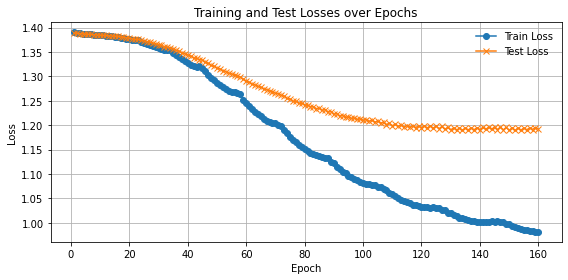

In [681]:
# Create the plot
plt.figure(figsize=(8, 4))

# Plot the train loss
plt.plot(losses_df['Epoch'], losses_df['Train Loss'], label='Train Loss', marker='o', linestyle='-')
# Plot the test loss
plt.plot(losses_df['Epoch'], losses_df['Test Loss'], label='Test Loss', marker='x', linestyle='-')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses over Epochs')

# Add a legend with a nice formatting for a scientific presentation
plt.legend(loc='upper right', frameon=False, fontsize='medium')

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()

# 6. Evaluation

In [682]:
gnn_model.eval()
dot_predictor.eval();

In [683]:
with torch.no_grad():
    h = gnn_model(edge_index)

#### 6.1 Train positive

In [684]:
with torch.no_grad():
    u,v = train_pos_edges
    prediction = torch.sigmoid(dot_predictor(u,v,h['user_h'], h['movie_h'])).flatten().numpy()

In [685]:
train_data_pos['prediction'] = prediction

<AxesSubplot:ylabel='Frequency'>

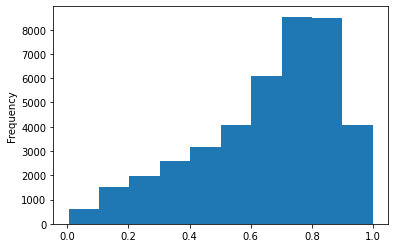

In [686]:
train_data_pos['prediction'].plot.hist()

#### 6.2 Train negative

In [687]:
with torch.no_grad():
    u,v = train_neg_edges
    prediction = torch.sigmoid(dot_predictor(u,v,h['user_h'], h['movie_h'])).flatten().numpy()

In [688]:
train_data_neg['prediction'] = prediction

<AxesSubplot:ylabel='Frequency'>

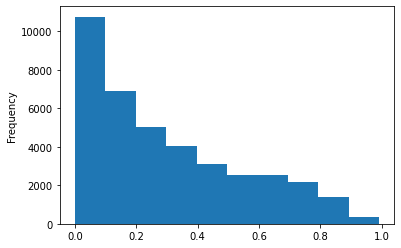

In [689]:
train_data_neg['prediction'].plot.hist()

#### 6.3 Test positive

In [690]:
with torch.no_grad():
    u,v = test_pos_edges
    prediction = torch.sigmoid(dot_predictor(u,v,h['user_h'], h['movie_h'])).flatten().numpy()

In [691]:
test_data_pos['prediction'] = prediction

<AxesSubplot:ylabel='Frequency'>

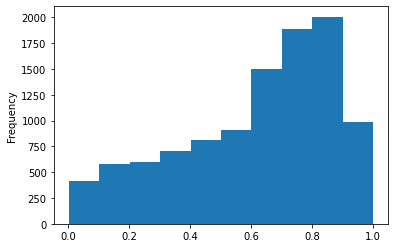

In [692]:
test_data_pos['prediction'].plot.hist()

#### 6.4 Test negative

In [693]:
with torch.no_grad():
    u,v = test_neg_edges
    prediction = torch.sigmoid(dot_predictor(u,v,h['user_h'], h['movie_h'])).flatten().numpy()

In [694]:
test_data_neg['prediction'] = prediction

<AxesSubplot:ylabel='Frequency'>

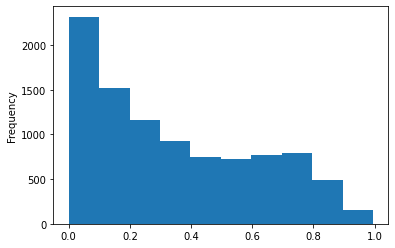

In [695]:
test_data_neg['prediction'].plot.hist()

---

In [696]:
test_data_pos

,index,userId,movieId,rating,timestamp,encoded_user,encoded_movie,pos_edge,prediction
0,5510,30,2398,4.0,945296110,29,1908,1,0.698421
1,46540,342,1147,5.0,945123519,341,915,1,0.939591
2,94291,624,4981,4.0,1019127669,623,3862,1,0.737810
3,41418,297,3030,5.0,1318703908,296,2433,1,0.815781
4,89116,594,1220,5.0,938962080,593,976,1,0.744748
...,...,...,...,...,...,...,...,...,...
10400,86127,576,1206,4.0,1005426731,575,962,1,0.811471
10401,73426,512,107141,4.0,1434150137,511,8448,1,0.615158
10402,12563,78,7458,5.0,1344470476,77,5152,1,0.706183
10403,2051,15,7034,4.5,1443384409,14,4938,1,0.271865


# 7. Embedding analysis

In [708]:
movie_embeddings = gnn_model.movie_embeddings.weight.data.numpy()

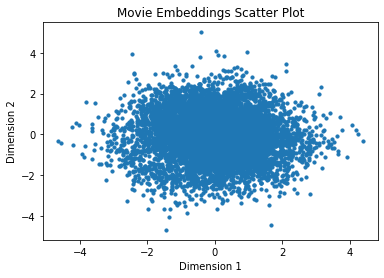

In [709]:
# Extract x and y coordinates from the embeddings array
x_coords = movie_embeddings[:, 0]
y_coords = movie_embeddings[:, 1]

# Create a scatter plot
plt.scatter(x_coords, y_coords, marker='o', s=10)

# Add labels and title
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Embeddings Scatter Plot')

# Show the plot
plt.show()

In [711]:
user_embeddings = gnn_model.user_embeddings.weight.data.numpy()

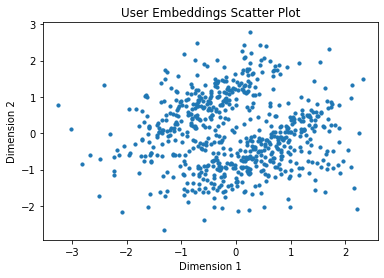

In [712]:
# Extract x and y coordinates from the embeddings array
x_coords = user_embeddings[:, 0]
y_coords = user_embeddings[:, 1]

# Create a scatter plot
plt.scatter(x_coords, y_coords, marker='o', s=10)

# Add labels and title
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('User Embeddings Scatter Plot')

# Show the plot
plt.show()